# Assignment 9 - Estimating Mesh, Texture and Camera using differentiable rendering

## 0. Install and Import modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/s3d21')
#from myshapenetutils import render2meshplotly

Mounted at /content/drive


In [2]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.7") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{torch.__version__[0:5:2]}"
        ])
        !pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   118  100   118    0     0    907      0 --:--:-- --:--:-- --:--:--   907
100  404k    0  404k    0     0   870k      0 --:--:-- --:--:-- --:--:-- 3014k
  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-k0ezxocc
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-k0ezxocc
  Running command git checkout -q 3c15a6c2469249c8b90a4f3e41e34350b8051b92
     |████████████████████████████████| 51kB 3.1MB/s 
     |████████████████████████████████| 645kB 8.7MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.4.0-cp37-cp37m-linux_x86_64.whl size=19951554 sha256=2e3a719d3c230e5f5f1ea414f1b974505bf99456ca3ff1983c7aa18b44d9a099
  Stored in directory: /tmp/pip-ephem-wheel-cache-uhd8tuxy/wheels/89/69/08/d864f516508b5d943259c6088baa150ebd

In [3]:
import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread

from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    look_at_rotation, 
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    HardFlatShader,
    TexturesVertex
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

If using **Google Colab**, fetch the utils file for plotting image grids:

In [4]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2021-06-19 19:19:01--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1472 (1.4K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.44K  --.-KB/s    in 0s      

2021-06-19 19:19:02 (20.4 MB/s) - ‘plot_image_grid.py’ saved [1472/1472]



OR if running **locally** uncomment and run the following cell:

In [5]:
#  from utils.plot_image_grid import image_grid

### 1. Load a mesh and texture file

Load an `.obj` file and it's associated `.mtl` file and create a **Textures** and **Meshes** object. 

#### Remember:
**Meshes** is a unique datastructure provided in PyTorch3D for working with batches of meshes of different sizes. 

**TexturesVertex** is an auxillary datastructure for storing vertex rgb texture information about meshes. 

If running this notebook using **Google Colab**, run the following cell to fetch the mesh obj and texture files and save it at the path `data/cow_mesh`:
If running locally, the data is already available at the correct path. 

In [6]:
!mkdir -p data/cow_mesh
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

--2021-06-19 19:19:02--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330659 (323K) [text/plain]
Saving to: ‘data/cow_mesh/cow.obj’

cow.obj             100%[===================>] 322.91K  1.22MB/s    in 0.3s    

2021-06-19 19:19:03 (1.22 MB/s) - ‘data/cow_mesh/cow.obj’ saved [330659/330659]

--2021-06-19 19:19:03--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155 [text/plain]
Saving to: ‘data/cow_mesh/cow.mtl’

cow.mtl             100%[=======

In [7]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

# As we already did in assignment 6, we scale normalize and center the target 
# mesh to fit in a sphere of radius 1 centered at (0,0,0). 
# (scale, center) will be used to bring the predicted mesh 
# to its original center and scale.  Note that normalizing the target mesh, 
# speeds up the optimization but is not necessary!
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((1.0 / float(scale)));

## 2. Dataset Creation

We sample different camera positions that encode multiple viewpoints of the cow.  We create a renderer with a shader that performs texture map interpolation.  We render a synthetic dataset of images of the textured cow mesh from multiple viewpoints.


In [8]:
# the number of different viewpoints from which we want to render the mesh.
num_views = 20

# Get a batch of viewing angles. 
#elev = torch.linspace(0, 360, num_views)
elev = torch.linspace(0, 360, num_views)
azim = torch.linspace(-180, 180, num_views)

# Place a point light in front of the object. As mentioned above, the front of 
# the cow is facing the -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Initialize an OpenGL perspective camera that represents a batch of different 
# viewing angles. All the cameras helper methods support mixed type inputs and 
# broadcasting. So we can view the camera from the a distance of dist=2.7, and 
# then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# We arbitrarily choose one particular view that will be used to visualize 
# results
camera = FoVPerspectiveCameras(device=device, R=R[None, 1, ...], 
                                              T=T[None, 1, ...]) 

# Define the settings for rasterization and shading. Here we set the output 
# image to be of size 128X128. As we are rendering images for visualization 
# purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to 
# rasterize_meshes.py for explanations of these parameters.  We also leave 
# bin_size and max_faces_per_bin to their default values of None, which sets 
# their values using huristics and ensures that the faster coarse-to-fine 
# rasterization method is used.  Refer to docs/notes/renderer.md for an 
# explanation of the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    perspective_correct=False,
    image_size=128, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Create a phong renderer by composing a rasterizer and a shader. The textured 
# phong shader will interpolate the texture uv coordinates for each vertex, 
# sample from a texture image and apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=camera,
        lights=lights
    )
)

# Create a batch of meshes by repeating the cow mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
# This also extends the textures. 
meshes = mesh.extend(num_views)

# Render the cow mesh from each viewing angle
target_images = renderer(meshes, cameras=cameras, lights=lights)

# Our multi-view cow dataset will be represented by these 2 lists of tensors,
# each of length num_views.
target_rgb = [target_images[i, ..., :3] for i in range(num_views)]
target_cameras = [FoVPerspectiveCameras(device=device, R=R[None, i, ...], 
                                                       T=T[None, i, ...]) for i in range(num_views)]

# RGB images
#image_grid(target_images.cpu().numpy(), rows=4, cols=5, rgb=True)
#plt.show()

Visualize the dataset:

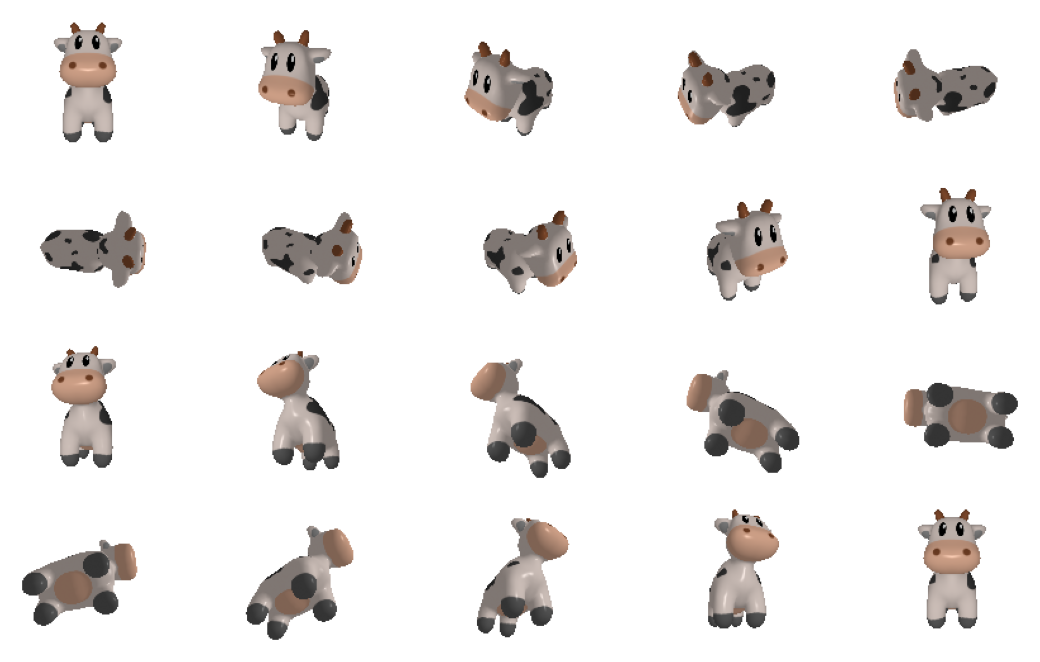

In [9]:
# RGB images
image_grid(target_images.cpu().numpy(), rows=4, cols=5, rgb=True)
plt.show()

## Questions

2.1 Present a high level description of a rendering pipeline based on **rasterization** (*not ray tracing!*). Which steps are inherently not differentiable? How could we re-design these operations to build a fully differentiable pipeline?

2.2 Place a point light in the scene and render the meshes again using the silhouette renderer. Does it make any difference? Why?

In [10]:
#https://github.com/facebookresearch/pytorch3d/blob/master/docs/notes/renderer_getting_started.md
#https://pytorch3d.org/docs/renderer_getting_started
#https://en.wikipedia.org/wiki/Graphics_pipeline
#https://www.khronos.org/opengl/wiki/Rendering_Pipeline_Overview
#https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-837-computer-graphics-fall-2012/lecture-notes/MIT6_837F12_Lec21.pdf
#Rasterizador parte das malhas de triangulos, transforma para o espaço da camera, depois é feita a projeção desses dados com o corte de clipping sendo aplicado.

In [11]:
# 2.2
# in this example, uses the same rasterization settings
sl_raster_settings = RasterizationSettings(
    perspective_correct = False,
    image_size = 128, 
    blur_radius = 0.0, 
    faces_per_pixel = 1,  
)
sl_renderer = MeshRenderer(
    rasterizer = MeshRasterizer(
        cameras = camera, 
        raster_settings = sl_raster_settings
    ),
    shader = SoftSilhouetteShader()
)

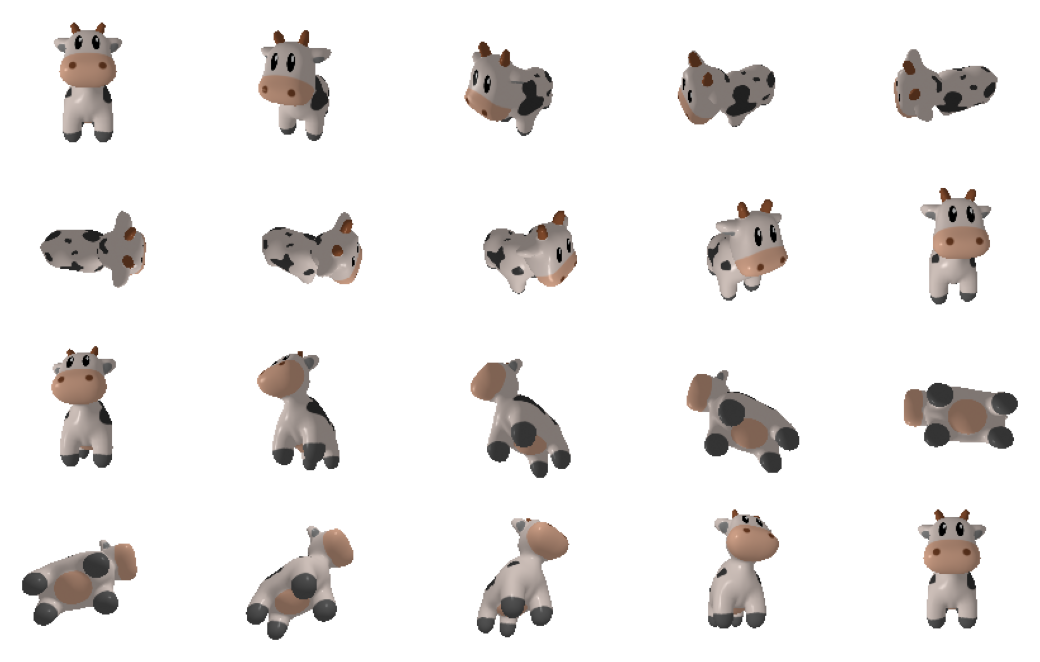

In [12]:
l1_lights = PointLights(device=device, location=[[3.0, 0.0, -3.0]])
l1_target_images = renderer(meshes, cameras=cameras, lights=l1_lights)
image_grid(l1_target_images.cpu().numpy(), rows=4, cols=5, rgb=True)
plt.show()

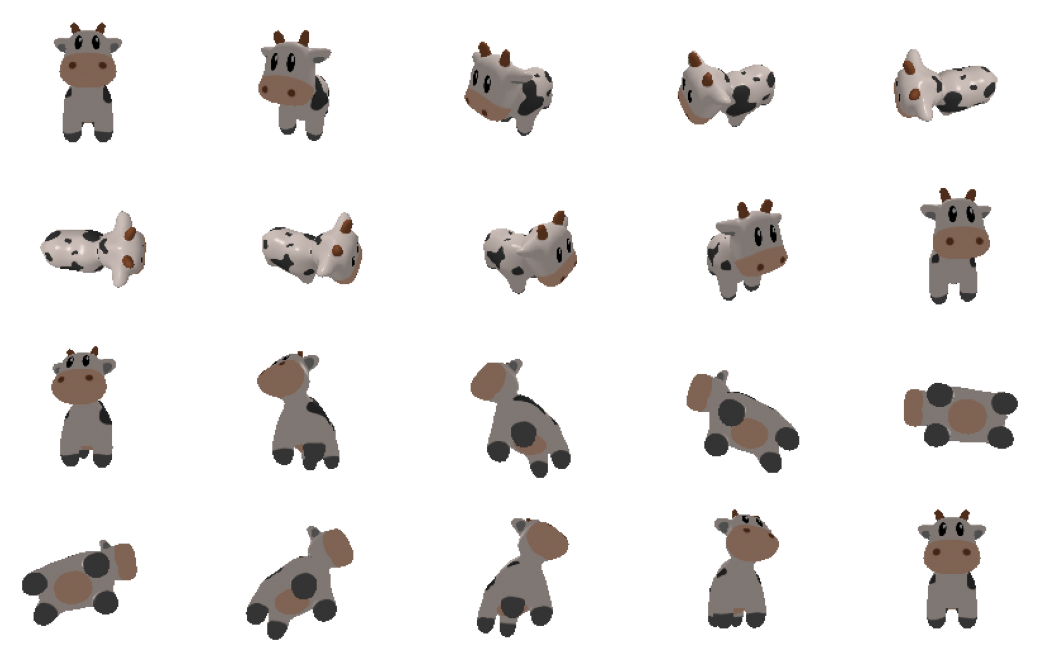

In [13]:
l2_lights = PointLights(device=device, location=[[0.0, 5.0, 3.0]])
l2_target_images = renderer(meshes, cameras=cameras, lights=l2_lights)
image_grid(l2_target_images.cpu().numpy(), rows=4, cols=5, rgb=True)
plt.show()

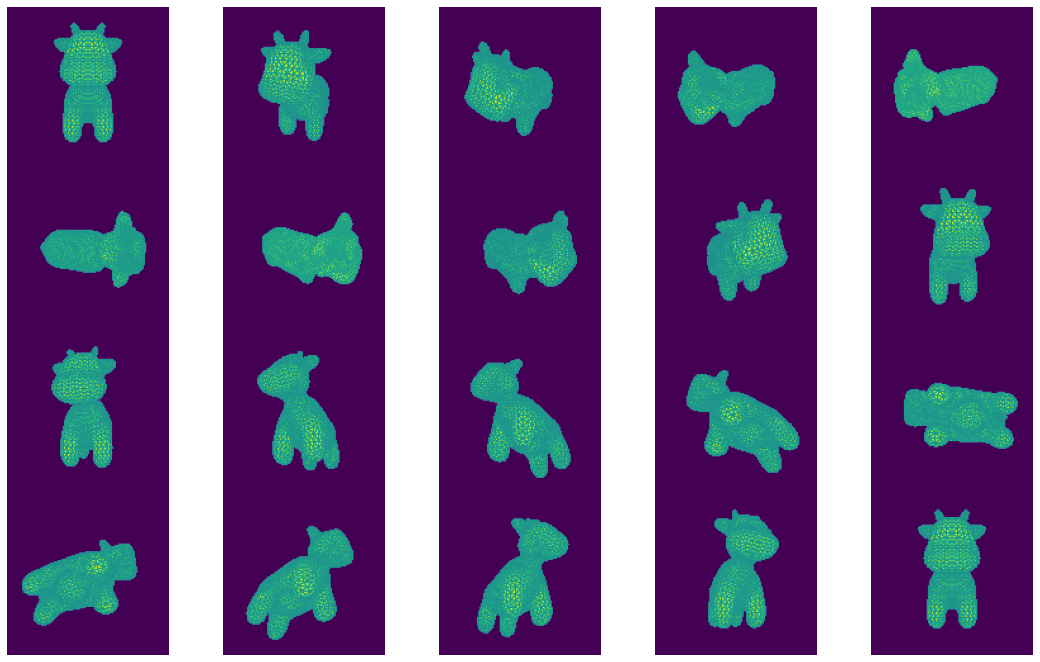

In [14]:
l1_sl_target_images = sl_renderer(meshes, cameras=cameras, lights=l1_lights)
image_grid(l1_sl_target_images.cpu().numpy(), rows=4, cols=5, rgb=False)
plt.show()

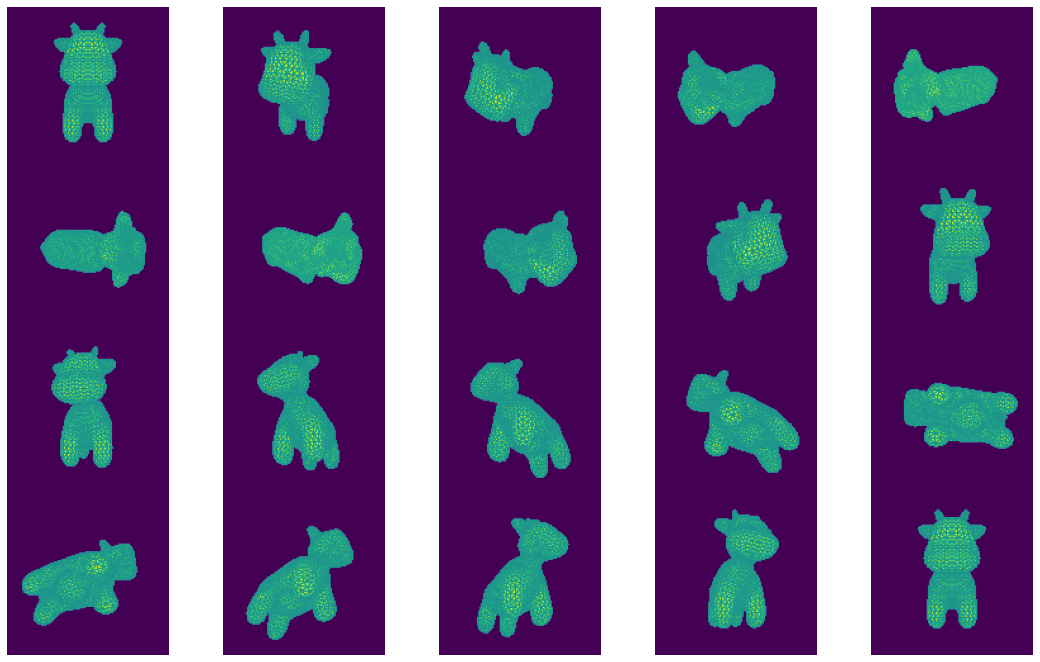

In [15]:
l2_sl_target_images = sl_renderer(meshes, cameras=cameras, lights=l2_lights)
image_grid(l2_sl_target_images.cpu().numpy(), rows=4, cols=5, rgb=False)
plt.show()

## 3. Mesh prediction via silhouette rendering
In the previous section, we created a dataset of images of multiple viewpoints of a cow.  

Later, we will fit a mesh to the rendered RGB images, as well as to just images of just the cow silhouette.  For the latter case, we will render a dataset of silhouette images.  Most shaders in PyTorch3D will output an alpha channel along with the RGB image as a 4th channel in an RGBA image.  The alpha channel encodes the probability that each pixel belongs to the foreground of the object. We contruct a soft silhouette shader to render this alpha channel.

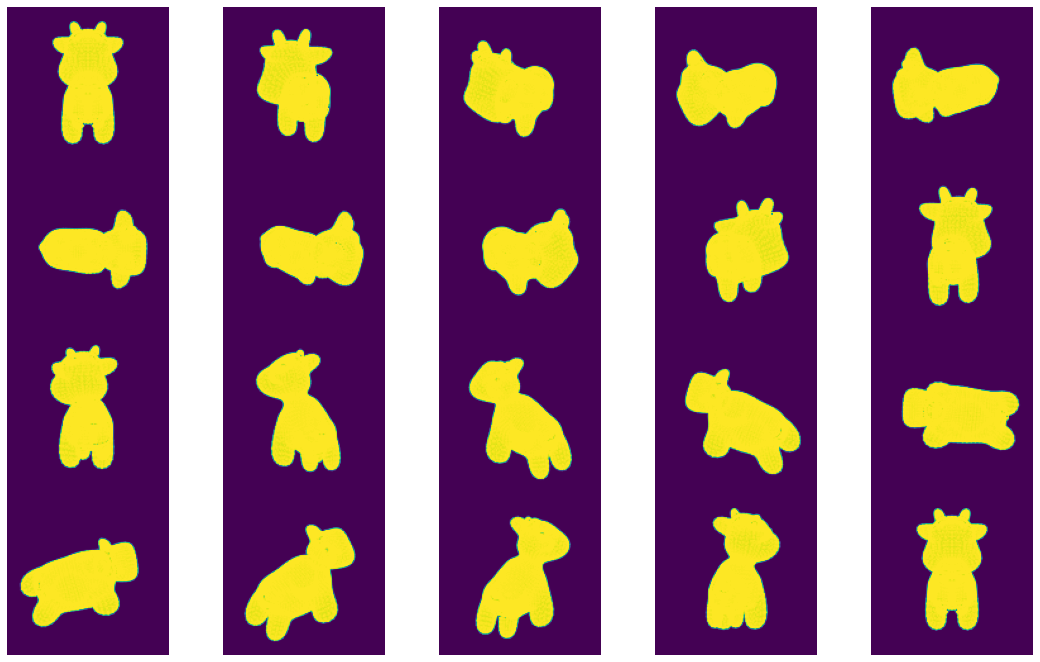

In [16]:
# Rasterization settings for silhouette rendering  
sigma = 1e-4
raster_settings_silhouette = RasterizationSettings(
    perspective_correct=False,
    image_size=128, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

# Render silhouette images.  The 3rd channel of the rendering output is 
# the alpha/silhouette channel
silhouette_images = renderer_silhouette(meshes, cameras=cameras, lights=lights)
target_silhouette = [silhouette_images[i, ..., 3] for i in range(num_views)]
#print(silhouette_images.shape)
# Visualize silhouette images
image_grid(silhouette_images.cpu().numpy(), rows=4, cols=5, rgb=False)
plt.show()

In this section, we predict a mesh by observing those target images without any knowledge of the ground truth cow mesh.  We assume we know the position of the cameras and lighting.

We first define some helper functions to visualize the results of our mesh prediction:

In [17]:
# Show a visualization comparing the rendered predicted mesh to the ground truth 
# mesh
def visualize_prediction(predicted_mesh, renderer=renderer_silhouette, 
                         target_image=target_rgb[1], title='', 
                         silhouette=False):
    inds = 3 if silhouette else range(3)
    #Always generate an image with the camera at index 1, as defined in section 2
    predicted_images = renderer(predicted_mesh)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.title(title)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())

    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.title("Target")
    plt.grid("off")
    plt.axis("off")

# Plot losses as a function of optimization iteration
def plot_losses(losses, plot_title = "Loss vs iterations"):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for k, l in losses.items():
        ax.plot(l['values'], label=k + " loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title(plot_title, fontsize="16")

def SaveObjMesh(mesh, obj_name):
  final_verts, final_faces = mesh.get_mesh_verts_faces(0)
  final_obj = os.path.join('./', obj_name+'.obj')
  save_obj(final_obj, final_verts, final_faces)

def visualize_prediction_empty (predicted_mesh, renderer=renderer_silhouette, 
                         target_image=target_rgb[1], title='', 
                         silhouette=False):
  return 0

Starting from a sphere mesh, we will learn offsets of each vertex such that the predicted mesh silhouette is more similar to the target silhouette image at each optimization step.  We begin by loading our initial sphere mesh:

In [18]:
# We initialize the source shape to be a sphere of radius 1.  
src_mesh = ico_sphere(4, device)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


We initialize settings, losses, and the optimizer that will be used to iteratively fit our mesh to the target silhouettes:

In [19]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 2
# Number of optimization steps
Niter = 2000
# Plot period for the losses
plot_period = 250

%matplotlib inline

# Optimize using rendered silhouette image loss, mesh edge loss, mesh normal 
# consistency, and mesh laplacian smoothing
losses = {"silhouette": {"weight": 1.0, "values": []},
          "edge": {"weight": 1.0, "values": []},
          "normal": {"weight": 0.01, "values": []},
          "laplacian": {"weight": 1.0, "values": []},
         }

# Losses to smooth / regularize the mesh shape
def update_mesh_shape_prior_losses(mesh, loss):
    # and (b) the edge length of the predicted mesh
    loss["edge"] = mesh_edge_loss(mesh)
    
    # mesh normal consistency
    loss["normal"] = mesh_normal_consistency(mesh)
    
    # mesh laplacian smoothing
    loss["laplacian"] = mesh_laplacian_smoothing(mesh, method="uniform")

# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in
# src_mesh
verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

We write an optimization loop to iteratively refine our predicted mesh from the sphere mesh into a mesh that matches the sillhouettes of the target images:

In [ ]:
loop = tqdm(range(Niter))

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)
    
    # Losses to smooth /regularize the mesh shape
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    update_mesh_shape_prior_losses(new_src_mesh, loss)
    
    # Compute the average silhouette loss over two random views, as the average 
    # squared L2 distance between the predicted silhouette and the target 
    # silhouette from our dataset
    for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
        images_predicted = renderer_silhouette(new_src_mesh, cameras=target_cameras[j], lights=lights)
        predicted_silhouette = images_predicted[..., 3]
        loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
        loss["silhouette"] += loss_silhouette / num_views_per_iteration
    
    # Weighted sum of the losses
    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(l)
    
    # Print the losses
    loop.set_description("total_loss = %.6f" % sum_loss)
    
    # Plot mesh
    if (i+1) % plot_period == 0:
        visualize_prediction(new_src_mesh, title="iter: %d" % (i+1), silhouette=True,
                             target_image=target_silhouette[1])
        
    # Optimization step
    sum_loss.backward()
    optimizer.step()

In [ ]:
visualize_prediction(new_src_mesh, silhouette=True, 
                     target_image=target_silhouette[1],
                     title="Optimized Mesh",)
plot_losses(losses, "Loss vs iterations - 2 views per iteration")

## Questions

3.1 Visualize the deformed mesh using `Plotly` and describe it qualitatively in comparinson with the target mesh. You can also download it and visualize it in another software if you wish.

3.2 Experiment changing the number of images `num_views_per_iteration` used to compute the silhouette loss each iteration. Would it still work if we computed the loss using `num_views_per_iteration`? What if we only had a single image, a single point of view, in our dataset?

3.3 Compare the target and source meshes sizes (number of vertices and faces). Are they close? Does the final result improve if you start from a source mesh with more vertices?

In [ ]:
#3.1
from myshapenetutils import render2meshplotly
render2meshplotly(mesh, new_src_mesh)

In [ ]:
#3.2
# Experiment changing the number of images num_views_per_iteration used to compute 
#  the silhouette loss each iteration. Would it still work if we computed the loss
#  using num_views_per_iteration? What if we only had a single image, a single point of view, in our dataset?
ico_mesh_4 = ico_sphere(4, device)
from mydifrenderingutils import OptimizeMeshVertices
ret_1viewperit = OptimizeMeshVertices(ico_mesh_4, mesh, device, 
                                      num_views_per_iteration=1,
                                      visualize_prediction_cb=visualize_prediction_empty,
                                      NumberOfIterations=2000)

In [ ]:
from myshapenetutils import render2meshplotly
render2meshplotly(mesh, ret_1viewperit["new_mesh"])

visualize_prediction(ret_1viewperit["new_mesh"], silhouette=True, 
                     target_image=target_silhouette[1],
                     title="Optimized Mesh",)
plot_losses(ret_1viewperit["losses"], "Loss vs iterations - 1 view per iteration")

In [ ]:
## 4 view per iteration
ico_mesh_4 = ico_sphere(4, device)
from mydifrenderingutils import OptimizeMeshVertices
ret_4viewperit = OptimizeMeshVertices(ico_mesh_4, mesh, device,
                                      num_views_per_iteration=4,
                                      visualize_prediction_cb=visualize_prediction_empty,
                                      NumberOfIterations=2000)

In [ ]:
from myshapenetutils import render2meshplotly
render2meshplotly(mesh, ret_4viewperit["new_mesh"])

visualize_prediction(ret_4viewperit["new_mesh"], silhouette=True, 
                     target_image=target_silhouette[1],
                     title="Optimized Mesh",)

plot_losses(ret_4viewperit["losses"], "Loss vs iterations - 4 views per iteration")

In [ ]:
## 8 view per iteration
ico_mesh_4 = ico_sphere(4, device)
from mydifrenderingutils import OptimizeMeshVertices
ret_8viewperit = OptimizeMeshVertices(ico_mesh_4, mesh, device,
                                      num_views_per_iteration=8,
                                      visualize_prediction_cb=visualize_prediction_empty,
                                      NumberOfIterations=2000)

In [ ]:
from myshapenetutils import render2meshplotly
render2meshplotly(mesh, ret_8viewperit["new_mesh"])

visualize_prediction(ret_8viewperit["new_mesh"], silhouette=True, 
                     target_image=target_silhouette[1],
                     title="Optimized Mesh",)

plot_losses(ret_8viewperit["losses"], "Loss vs iterations - 8 views per iteration")

In [ ]:
SaveObjMesh(new_src_mesh, "3_2_cow_2_views_per_iteration")
SaveObjMesh(ret_1viewperit["new_mesh"], "3_2_cow_1_views_per_iteration")
SaveObjMesh(ret_4viewperit["new_mesh"], "3_2_cow_4_views_per_iteration")
SaveObjMesh(ret_8viewperit["new_mesh"], "3_2_cow_8_views_per_iteration")

In [ ]:
#3.3
#https://pytorch3d.readthedocs.io/en/latest/_modules/pytorch3d/structures/meshes.html
print("Cow Mesh Vertices: %d" % mesh.verts_packed().shape[0])
print("Sphere level 4 Mesh Vertices: %d" % new_src_mesh.verts_packed().shape[0])
ico_mesh_5 = ico_sphere(5, device)
print("Sphere level 5 Mesh Vertices: %d" % ico_mesh_5.verts_packed().shape[0])

In [ ]:
ico_mesh_5 = ico_sphere(5, device)
from mydifrenderingutils import OptimizeMeshVertices
ret_iso5_2viewperit = OptimizeMeshVertices(ico_mesh_5, mesh, device,
                                           num_views_per_iteration=2,
                                           visualize_prediction_cb=visualize_prediction_empty,
                                           NumberOfIterations=2000)

In [ ]:
SaveObjMesh(ret_iso5_2viewperit["new_mesh"], "3_3_cow_2_views_per_iteration")

from myshapenetutils import render2meshplotly
render2meshplotly(mesh, ret_iso5_2viewperit["new_mesh"])

visualize_prediction(ret_iso5_2viewperit["new_mesh"], silhouette=True, 
                     target_image=target_silhouette[1],
                     title="Optimized Mesh",)

plot_losses(ret_iso5_2viewperit["losses"], "Loss vs iterations - 2 views per iteration - ico_sphere level 5")

In [ ]:
ico_mesh_5 = ico_sphere(5, device)
from mydifrenderingutils import OptimizeMeshVertices
ret_iso5_4viewperit = OptimizeMeshVertices(ico_mesh_5, mesh, device,
                                           num_views_per_iteration=4,
                                           visualize_prediction_cb=visualize_prediction_empty,
                                           NumberOfIterations=2000)

In [ ]:
SaveObjMesh(ret_iso5_4viewperit["new_mesh"], "3_3_cow_4_views_per_iteration")

from myshapenetutils import render2meshplotly
render2meshplotly(mesh, ret_iso5_4viewperit["new_mesh"])

visualize_prediction(ret_iso5_4viewperit["new_mesh"], silhouette=True, 
                     target_image=target_silhouette[1],
                     title="Optimized Mesh",)

plot_losses(ret_iso5_4viewperit["losses"], "Loss vs iterations - 4 views per iteration - ico_sphere level 5")


#Se observarmos as vistas, percebe-se que elas não conseguem moldar de uma boa forma o pescoço

In [ ]:
ico_mesh_5 = ico_sphere(5, device)
from mydifrenderingutils import OptimizeMeshVertices
ret_iso5_4viewperit_elev00 = OptimizeMeshVertices(ico_mesh_5, mesh, device,
                                           num_views_per_iteration=2,
                                           visualize_prediction_cb=visualize_prediction_empty,
                                           NumberOfIterations=2000,
                                           elev0=0, elev1=0)

In [ ]:
SaveObjMesh(ret_iso5_4viewperit_elev00["new_mesh"], "3_3_cow_2_views_per_iteration_elev00")

from myshapenetutils import render2meshplotly
render2meshplotly(mesh, ret_iso5_4viewperit_elev00["new_mesh"])

visualize_prediction(ret_iso5_4viewperit_elev00["new_mesh"], silhouette=True, 
                     target_image=target_silhouette[1],
                     title="Optimized Mesh",)

plot_losses(ret_iso5_4viewperit_elev00["losses"], "Loss vs iterations - 4 views per iteration - ico_sphere level 5 - elev [0,0]")

## 4. Mesh and texture prediction via textured rendering
We can predict both the mesh and its texture if we add an additional loss based on the comparing a predicted rendered RGB image to the target image. As before, we start with a sphere mesh.  We learn both translational offsets and RGB texture colors for each vertex in the sphere mesh.  Since our loss is based on rendered RGB pixel values instead of just the silhouette, we use a **SoftPhongShader** instead of a **SoftSilhouetteShader**.

In [ ]:
# Rasterization settings for differentiable rendering, where the blur_radius
# initialization is based on Liu et al, 'Soft Rasterizer: A Differentiable 
# Renderer for Image-based 3D Reasoning', ICCV 2019
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    perspective_correct=False,
    image_size=128, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
)

# Differentiable soft renderer using per vertex RGB colors for texture
renderer_textured = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_soft
    ),
    shader=SoftPhongShader(device=device, 
        cameras=camera,
        lights=lights)
)

We initialize settings, losses, and the optimizer that will be used to iteratively fit our mesh to the target RGB images:

In [ ]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 2
# Number of optimization steps
Niter = 2000
# Plot period for the losses
plot_period = 250

%matplotlib inline

# Optimize using rendered RGB image loss, rendered silhouette image loss, mesh 
# edge loss, mesh normal consistency, and mesh laplacian smoothing
losses = {"rgb":        {"weight": 1.0,  "values": []},
          "silhouette": {"weight": 1.0,  "values": []},
          "edge":       {"weight": 1.0,  "values": []},
          "normal":     {"weight": 0.01, "values": []},
          "laplacian":  {"weight": 1.0,  "values": []},
         }

# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in 
# src_mesh
src_mesh = ico_sphere(4, device)
verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# We will also learn per vertex colors for our sphere mesh that define texture 
# of the mesh
sphere_verts_rgb = torch.full([1, verts_shape[0], 3], 0.5, device=device, requires_grad=True)

# The optimizer
optimizer = torch.optim.SGD([deform_verts, sphere_verts_rgb], lr=1.0, momentum=0.9)

We write an optimization loop to iteratively refine our predicted mesh and its vertex colors from the sphere mesh into a mesh that matches the target images:

In [ ]:
loop = tqdm(range(Niter))

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)
    
    # Add per vertex colors to texture the mesh
    new_src_mesh.textures = TexturesVertex(verts_features=sphere_verts_rgb) 
    
    # Losses to smooth /regularize the mesh shape
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    update_mesh_shape_prior_losses(new_src_mesh, loss)
    
    # Randomly select two views to optimize over in this iteration.  Compared
    # to using just one view, this helps resolve ambiguities between updating
    # mesh shape vs. updating mesh texture
    for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
        images_predicted = renderer_textured(new_src_mesh, cameras=target_cameras[j], lights=lights)

        # Squared L2 distance between the predicted silhouette and the target 
        # silhouette from our dataset
        predicted_silhouette = images_predicted[..., 3]
        loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
        loss["silhouette"] += loss_silhouette / num_views_per_iteration
        
        # Squared L2 distance between the predicted RGB image and the target 
        # image from our dataset
        predicted_rgb = images_predicted[..., :3]
        loss_rgb = ((predicted_rgb - target_rgb[j]) ** 2).mean()
        loss["rgb"] += loss_rgb / num_views_per_iteration
    
    # Weighted sum of the losses
    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(l)
    
    # Print the losses
    loop.set_description("total_loss = %.6f" % sum_loss)
    
    # Plot mesh
    if (i+1) % plot_period == 0:
        visualize_prediction(new_src_mesh, 
                             renderer=renderer_textured, 
                             title="iter: %d" % (i+1), 
                             silhouette=False)
        
    # Optimization step
    sum_loss.backward()
    optimizer.step()


In [ ]:
plot_losses(losses, "Loss vs iterations - 2 views per iteration")

## Save the final predicted mesh

In [ ]:
# Fetch the verts and faces of the final predicted mesh
final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

# Scale normalize back to the original target size
final_verts = final_verts * scale + center

# Store the predicted mesh using save_obj
final_obj = os.path.join('./', '4_0_final_model.obj')
save_obj(final_obj, final_verts, final_faces)

## Questions

4.1 Compare the target and source meshes and describe the result qualitatively.

4.2 Do you think it could be better? Analyze the losses values, the meshes, the hyperparemeters and try other values. Even if you don't get a better result, try to explain your intutition for the changes you made.

4.3 Make a copy of the target mesh and now try to optimize the texture only, starting from the ground truth geometry. Describe your result.

**[EXTRA] E.1 Deform the textured cow into a sphere - you can choose to supervise with multi-view images (of a sphere) or the sphere geometry. Save the result, then deform the textured sphere into the cow again. What happened?**

In [ ]:
#4.1
#4.1 Compare the target and source meshes and describe the result qualitatively.
from myshapenetutils import render2meshplotly
render2meshplotly(mesh, new_src_mesh)

In [ ]:
#4.2
#4.2 Do you think it could be better? Analyze the losses values, the meshes, 
#    the hyperparemeters and try other values. Even if you don't get a better
#    result, try to explain your intutition for the changes you made.
ico_mesh_4 = ico_sphere(4, device)
from mydifrenderingutils import OptimizeMeshVerticesAndTextures
rgb_4_2_half_weights = OptimizeMeshVerticesAndTextures(ico_mesh_4, mesh, device,
                                                       LossSILHOUETTE = 0.5,
                                                       LossEDGE       = 0.5,
                                                       LossNORMAL     = 0.005,
                                                       LossLAPLACIAN  = 0.5,
                                                       NumberOfIterations=2000)
plot_losses(rgb_4_2_half_weights["losses"])

In [ ]:
from myshapenetutils import render2meshplotly
render2meshplotly(mesh, rgb_4_2_half_weights["new_mesh"])

In [ ]:
ico_mesh_4 = ico_sphere(4, device)
from mydifrenderingutils import OptimizeMeshVerticesAndTextures
rgb_4_2_5000_iterations = OptimizeMeshVerticesAndTextures(ico_mesh_4, mesh, device,
                                                          LossSILHOUETTE = 0.5,
                                                          LossEDGE       = 0.5,
                                                          LossNORMAL     = 0.005,
                                                          LossLAPLACIAN  = 0.5,
                                                          NumberOfIterations=5000)
plot_losses(rgb_4_2_5000_iterations["losses"])

In [ ]:
from myshapenetutils import render2meshplotly
render2meshplotly(mesh, rgb_4_2_5000_iterations["new_mesh"])

In [ ]:
#4.3
#4.3 Make a copy of the target mesh and now try to optimize the texture only, 
#    starting from the ground truth geometry. Describe your result.
from mydifrenderingutils import OptimizeMeshVerticesAndTextures
rgb_4_3_test_from_gt = OptimizeMeshVerticesAndTextures(mesh, mesh, device,
                                      LossSILHOUETTE = 0.0,
                                      LossEDGE       = 0.0,
                                      LossNORMAL     = 0.0,
                                      LossLAPLACIAN  = 0.0,
                                      NumberOfIterations=2000)

rgb_4_3_test_from_gt["losses"].pop("silhouette")
rgb_4_3_test_from_gt["losses"].pop("edge")
rgb_4_3_test_from_gt["losses"].pop("normal")
rgb_4_3_test_from_gt["losses"].pop("laplacian")
plot_losses(rgb_4_3_test_from_gt["losses"])

In [ ]:
from myshapenetutils import render2meshplotly
render2meshplotly(mesh, rgb_4_3_test_from_gt["new_mesh"])

In [ ]:
#E.1
#[EXTRA] E.1 Deform the textured cow into a sphere - you can choose to supervise
#            with multi-view images (of a sphere) or the sphere geometry. Save
#            the result, then deform the textured sphere into the cow again.
#            What happened?
ico_mesh_4 = ico_sphere(4, device)
from mydifrenderingutils import OptimizeMeshVertices
cow_to_sphere = OptimizeMeshVertices(mesh, ico_mesh_4, device,
                                     num_views_per_iteration=2,
                                     visualize_prediction_cb=visualize_prediction_empty,
                                     NumberOfIterations=2000)

In [ ]:
from myshapenetutils import render2meshplotly
render2meshplotly(mesh, cow_to_sphere["new_mesh"], title1="Initial Mesh", title2="Cow to Sphere Deformation")

In [ ]:
cow_to_sphere_mesh = cow_to_sphere["new_mesh"].clone().detach()
sphere_to_cow = OptimizeMeshVertices(cow_to_sphere_mesh, mesh, device,
                                     num_views_per_iteration=2,
                                     visualize_prediction_cb=visualize_prediction_empty,
                                     NumberOfIterations=2000)

In [ ]:
from myshapenetutils import render2meshplotly
render2meshplotly(sphere_to_cow["new_mesh"], mesh, title1="Sphere to Cow Deformation", title2="Mesh Reference")

In [ ]:
e1_meshes = sphere_to_cow["new_mesh"].extend(num_views)
e1_target_images = renderer(e1_meshes.detach(), cameras=cameras, lights=lights)
image_grid(e1_target_images.cpu().numpy(), rows=4, cols=5, rgb=True)
plt.show()

---------

# 5 Camera Position Optimization

Until now, we assumed we knew the cameras and we learned how to infer the geometry and texture of a mesh using a differentiable renderer and supervising the training with the multiview images dataset. 

Now, we'll assume we have the geometry and images of the object, but we don't know the cameras. Can we infer the camera position by backpropagation?

In [20]:
import torch.nn as nn
import torch.nn.functional as F
import imageio
from skimage import img_as_ubyte

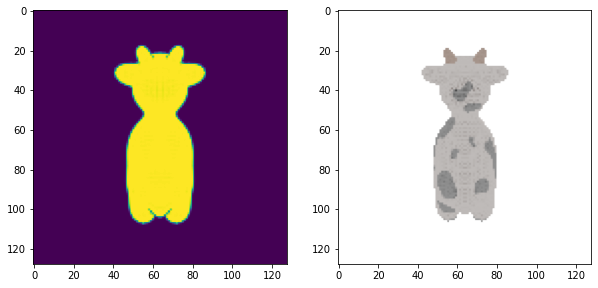

In [35]:
# Select the viewpoint using spherical angles  
distance = 3   # distance from camera to the object
############################################# WORKS
elevation = 50.0   # angle of elevation in degrees
azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis. 
############################################## WORKS
#elevation = 0.0   # angle of elevation in degrees
#azimuth = 90.0  # No rotation so the camera is positioned on the +Z axis. 
############################################## NOT WORK
#elevation = 0.0   # angle of elevation in degrees
#azimuth = -90.0  # No rotation so the camera is positioned on the +Z axis. 
############################################## NOT WORK
#elevation = 0.0   # angle of elevation in degrees
#azimuth = 180.0  # No rotation so the camera is positioned on the +Z axis. 
############################################## WORKS
#elevation = 0.0   # angle of elevation in degrees
#azimuth =  45.0  # No rotation so the camera is positioned on the +Z axis. 
###############################################

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

# Render the mesh providing the values of R and T. 
silhouete = renderer_silhouette(meshes_world=mesh, R=R, T=T)
image_ref = renderer(meshes_world=mesh, R=R, T=T)

silhouete = silhouete.cpu().numpy()
image_ref = image_ref.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(silhouete.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(image_ref.squeeze())
plt.grid(False)

### Set up a basic model 

Here we create a simple model class and initialize a parameter for the camera position. 

In [36]:
class Model(nn.Module):
    def __init__(self, meshes, renderer, image_ref):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer = renderer
        
        # Get the silhouette of the reference RGB image by finding all non-white pixel values. 
        image_ref = torch.from_numpy((image_ref[..., :3].max(-1) != 1).astype(np.float32))
        self.register_buffer('image_ref', image_ref)
        
        # Create an optimizable parameter for the x, y, z position of the camera. 
        self.camera_position = nn.Parameter(
            torch.from_numpy(np.array([3.0,  6.9, +2.5], dtype=np.float32)).to(meshes.device))

    def forward(self):
        
        # Render the image using the updated camera position. Based on the new position of the 
        # camer we calculate the rotation and translation matrices
        R = look_at_rotation(self.camera_position[None, :], device=self.device)  # (1, 3, 3)
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        
        image = self.renderer(meshes_world=self.meshes.clone(), R=R, T=T)
        
        # Calculate the silhouette loss
        loss = torch.sum((image[..., 3] - self.image_ref) ** 2)
        return loss, image
  

### Initialize the model and optimizer

Now we can create an instance of the **model** above and set up an **optimizer** for the camera position parameter. 

In [37]:
# We will save images periodically and compose them into a GIF.
filename_output = "./cow_optimization_demo_5_0_" + str(int(elevation)) + "_" + str(int(azimuth)) + ".gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

# Initialize a model using the renderer, mesh and reference image
model = Model(meshes=mesh, renderer=renderer_silhouette, image_ref=image_ref).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

### Visualize the starting position and the reference position

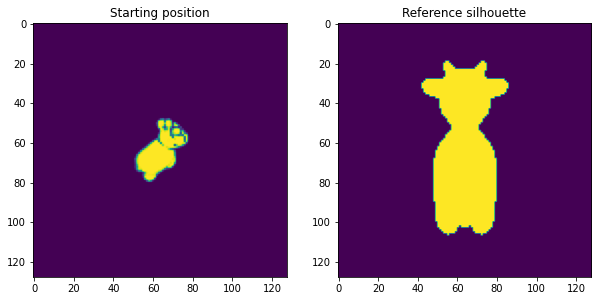

In [38]:
plt.figure(figsize=(10, 10))

_, image_init = model()
plt.subplot(1, 2, 1)
plt.imshow(image_init.detach().squeeze().cpu().numpy()[..., 3])
plt.grid(False)
plt.title("Starting position")

plt.subplot(1, 2, 2)
plt.imshow(model.image_ref.cpu().numpy().squeeze())
plt.grid(False)
plt.title("Reference silhouette");


### Run the optimization 

We run several iterations of the forward and backward pass and save outputs every 10 iterations. When this has finished take a look at `./cow_optimization_demo.gif` for a cool gif of the optimization process!

In [ ]:
loop = tqdm(range(200))
for i in loop:
    optimizer.zero_grad()
    loss, _ = model()
    loss.backward()
    optimizer.step()
    
    loop.set_description('Optimizing (loss %.4f)' % loss.data)
    
    if loss.item() < 100:
        print("loss below threshold")
        break
    
    # Save outputs to create a GIF. 
    if i % 10 == 0:
        R = look_at_rotation(model.camera_position[None, :], device=model.device)
        T = -torch.bmm(R.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        image = renderer(meshes_world=model.meshes.clone(), R=R, T=T)
        image = image[0, ..., :3].detach().squeeze().cpu().numpy()
        image = img_as_ubyte(image)
        writer.append_data(image)
        
        plt.figure()
        plt.imshow(image[..., :3])
        plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
        plt.grid("off")
        plt.axis("off")
    
writer.close()

# Questions

5.1 Evaluate how close our prediction is to the ground truth camera position. Explain your metric.

5.2 Experiment with other views - different target images and different initial positions to the camera model. Does it always work?

**EXTRA E.2: Could you estimate the scene illumination - in this case, the location of a single point light? Set up and run an example**

(1, 128, 128, 4)


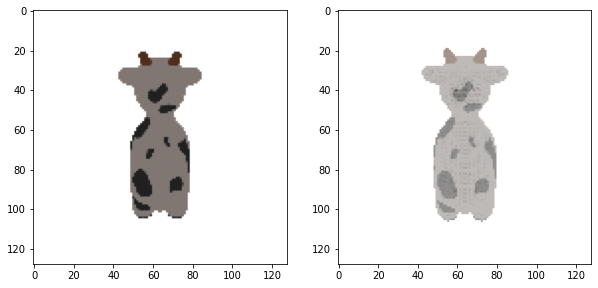

In [26]:
#5.1
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[..., :3])
plt.grid(False)
plt.subplot(1, 2, 2)
print(image_ref.shape)
plt.imshow(image_ref.squeeze())
plt.grid(False)

In [ ]:
from pytorch3d.transforms.so3 import (
    so3_exponential_map,
    so3_relative_angle,   
)

R1, T1 = look_at_view_transform(distance, elevation, azimuth, device=device)
R2 = look_at_rotation(model.camera_position[None, :], device=model.device)
T2 = -torch.bmm(R.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]   # (1, 3)
print(R1, T1)
print(R2, T2)

def calc_camera_distance(R1, R2, T1, T2):
    """
    Calculates the divergence of a batch of pairs of cameras cam_1, cam_2.
    The distance is composed of the cosine of the relative angle between 
    the rotation components of the camera extrinsics and the L2 distance
    between the translation vectors.
    """
    # rotation distance
    R_distance = (1.-so3_relative_angle(R1, R2, cos_angle=True)).mean()
    # translation distance
    T_distance = ((T1 - T2)**2).sum(1).mean()
    # the final distance is the sum
    return R_distance + T_distance
    
print(calc_camera_distance(R1, R2, T1, T2))

In [27]:
#5.2
# not always work
############################################# WORKS
#elevation = 50.0   # angle of elevation in degrees
#azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis. 
############################################## WORKS
#elevation = 0.0   # angle of elevation in degrees
#azimuth = 90.0  # No rotation so the camera is positioned on the +Z axis. 
############################################## NOT WORK
#elevation = 0.0   # angle of elevation in degrees
#azimuth = -90.0  # No rotation so the camera is positioned on the +Z axis. 
############################################## NOT WORK
#elevation = 0.0   # angle of elevation in degrees
#azimuth = 180.0  # No rotation so the camera is positioned on the +Z axis. 
############################################## WORKS
#elevation = 0.0   # angle of elevation in degrees
#azimuth =  45.0  # No rotation so the camera is positioned on the +Z axis. 
###############################################


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import imageio
from skimage import img_as_ubyte

# Select the viewpoint using spherical angles  
e_2_cam_distance = 3   # distance from camera to the object
e_2_cam_elevation = 50.0   # angle of elevation in degrees
e_2_cam_azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis. 

e_2_cam_R, e_2_cam_T = look_at_view_transform(e_2_cam_distance, e_2_cam_elevation, e_2_cam_azimuth, device=device)
e_2_cam_cameras = FoVPerspectiveCameras(device=device, R=e_2_cam_R, T=e_2_cam_T)

e_2_cam_lights = PointLights(device=device, location=[[1.0, 1.0, 2.0]])

sigma = 1e-4
e_2_cam_light_raster_settings = RasterizationSettings(
    perspective_correct=False,
    image_size=128, 
    #blur_radius=0.0,
    #faces_per_pixel=1,
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
)

e_2_cam_light_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=e_2_cam_cameras, 
        raster_settings=e_2_cam_light_raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=e_2_cam_cameras,
        lights=e_2_cam_lights
    )
)

image_rgb_ref = renderer(meshes_world=mesh, cameras=e_2_cam_cameras, lights=e_2_cam_lights)
c_image_rgb_ref = image_rgb_ref[0, ..., :3].cpu().numpy()

plt.figure(figsize=(5, 5))
plt.imshow(c_image_rgb_ref.squeeze())
plt.grid(False)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import imageio
from skimage import img_as_ubyte

class ModelE2(nn.Module):
    def __init__(self, meshes, mesh_renderer, image_ref, camera):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer = mesh_renderer
        self.camera = camera
        
        # Get the silhouette of the reference RGB image by finding all non-white pixel values. 
        #image_ref = torch.from_numpy((image_ref[..., :3].max(-1) != 1).astype(np.float32))
        image_ref = torch.from_numpy(image_ref[..., :3])
        self.register_buffer('image_ref', image_ref)
        
        # Create an optimizable parameter for the x, y, z position of the camera. 
        #self.camera_position = nn.Parameter(
        #    torch.from_numpy(np.array([3.0,  6.9, +2.5], dtype=np.float32)).to(meshes.device))
        
        self.light_position = nn.Parameter(
            torch.from_numpy(np.array([0.0,  0.0, 0.0], dtype=np.float32)).to(meshes.device))

    def forward(self):
        # Render the image using the updated light position.
        cam_lights = PointLights(device=self.device, location=self.light_position[None, :])
        image = self.renderer(meshes_world=self.meshes.clone(), cameras=self.camera, lights=cam_lights)
        
        loss = torch.sum((image[..., :3] - self.image_ref) ** 2)
        return loss, image
  
# We will save images periodically and compose them into a GIF.
filename_output = "./cow_optimization_demo_e_2.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

# Initialize a model using the renderer, mesh and reference image
modele2 = ModelE2(meshes=mesh, mesh_renderer=e_2_cam_light_renderer, image_ref=c_image_rgb_ref, camera=e_2_cam_cameras).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizere2 = torch.optim.Adam(modele2.parameters(), lr=0.05)

In [ ]:
plt.figure(figsize=(10, 10))

_, e2_image_init = modele2()
plt.subplot(1, 2, 1)
plt.imshow(e2_image_init.detach().squeeze().cpu().numpy()[..., :3])
plt.grid(False)
plt.title("Before Optimization")

plt.subplot(1, 2, 2)
plt.imshow(modele2.image_ref.cpu().numpy().squeeze())
plt.grid(False)
plt.title("Reference Light");

loop = tqdm(range(200))
for i in loop:
    optimizere2.zero_grad()
    loss, _ = modele2()
    loss.backward()
    optimizere2.step()
    
    loop.set_description('Optimizing (loss %.4f)' % loss.data)
    
    if loss.item() < 1:
        print("loss below threshold")
        break
    
    # Save outputs to create a GIF. 
    if i % 10 == 0:
        e2_lights = PointLights(device=device, location=modele2.light_position[None, :])
        image = renderer(meshes_world=modele2.meshes.clone(), cameras=e_2_cam_cameras, lights=e2_lights)
        image = image[0, ..., :3].detach().squeeze().cpu().numpy()
        image = img_as_ubyte(image)
        writer.append_data(image)
        
        #plt.figure()
        #plt.imshow(image[..., :3])
        #plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
        #plt.grid("off")
        #plt.axis("off")
    
writer.close()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[..., :3])
plt.title("After Optimization")

plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(modele2.image_ref.cpu().numpy().squeeze())#image_ref.squeeze())
plt.grid(False)
plt.title("Reference Light");